# 从零开始搭建扩散模型

本章涵盖的知识点如下：
- 退化过程（向数据添加噪声）
- 什么事UNet网络模型以及如何从零开始实现一个简单的UNet网络模型
- 扩散模型的训练
- 采样理论

然后，本章将介绍我们所展示的模型版本和Diffusers库中DDPM版本实现过程的区别，涵盖的知识点如下：
- 小型UNet网络模型的改进方法
- DDPM噪声计划
- 训练目标的差异
- 调节时间步
- 采样方法

## 1. 环境准备

### 1.1 环境的创建与导入

In [1]:
import torch
import torchvision 
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available()
                      else 'mps' if torch.mps.is_available()
                      else 'cpu')
print(device)

/Users/hongshuo/Diffusion-Model/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/hongshuo/Diffusion-Model/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


mps


### 1.2 数据集测试
我们将使用一个非常小的经典数据集MNIST来进行测试

MNIST数据集中的每张图都是一个阿拉伯数字的 $28\times28$ 像素的灰度图，每个像素的取值区间是[0,1] 

Input Size: torch.Size([8, 1, 28, 28])
Labels tensor([7, 6, 0, 5, 7, 0, 0, 0])


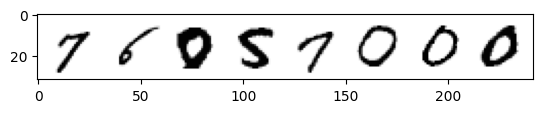

In [2]:
train_dataset = torchvision.datasets.MNIST(root='../Datasets/MNIST',train=True,download=False,transform=torchvision.transforms.ToTensor())
train_dataloader = DataLoader(train_dataset,batch_size=8,shuffle=True)
x,y = next(iter(train_dataloader))
print('Input Size:',x.shape)
print('Labels',y)
plt.imshow(torchvision.utils.make_grid(x)[0],cmap='Greys')

## 2. 扩散模型之退化过程
我们可以通过一个简单的方法来控制内容损坏的程度。如果需要引入一个参数来控制输入的“噪声量”，那么我们可以在配置好的环境中输入如下的代码：

In [3]:
def corrupt(x,amount):
    """
    根据amount的大小为输入x添加噪声,这就是退化过程
    """
    noise = torch.rand_like(x)
    amount = amount.view(-1,1,1,1) # 整理形状以保证广播机制不出错
    return x*(1-amount) + noise*amount

如果 $amount=0$ ，则返回输入，不做任何更改；如果 $amount=1$ ，我们将得到一个纯粹的噪声。通过这种方式，我们可以将输入内容和噪声混合，并把混合后的结果保持在相同的范围内 $0\sim1$。

接下来对结果进行可视化，看看是否符合预期：

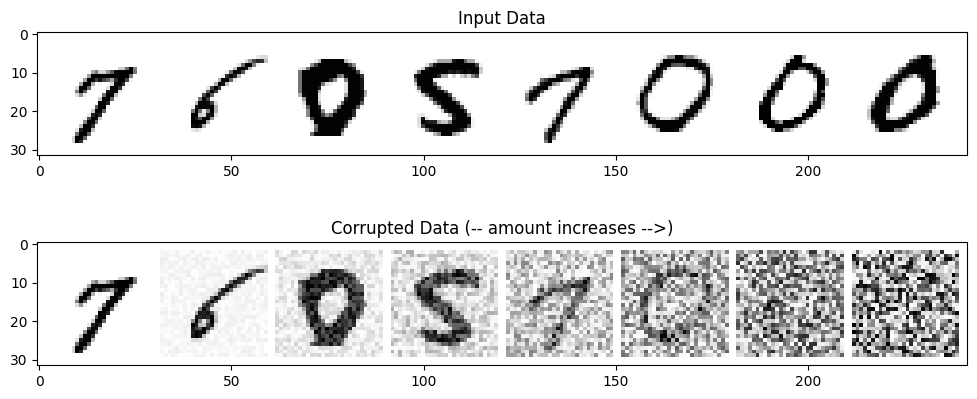

In [4]:
# 绘制输入数据
fig,axs = plt.subplots(2,1,figsize=(12,5))
axs[0].set_title("Input Data")
axs[0].imshow(torchvision.utils.make_grid(x)[0],cmap="Greys")

# 加入噪声
amount = torch.linspace(0,1,x.shape[0]) # 从0到1 -> 退化逐渐强烈直到完全成为噪声
noise_x = corrupt(x,amount)

# 绘制添加噪声后的输出
axs[1].set_title("Corrupted Data (-- amount increases -->)")
axs[1].imshow(torchvision.utils.make_grid(noise_x)[0],cmap="Greys")

## 3. 扩散模型之训练
### 3.1 UNet网络
UNet网络由一条 **“下行路径”** 和一条 **“上行路径”** 组成。“下行路径”会压缩通过该路径的数据维度，而“上行路径”则会将数据扩展回原始维度（类似于自动编码器）。UNet中的残差连接允许信息和梯度在不同层级之间流动。 *（联想到了Bottleneck Block）*

<img src="imgs/UNet-Structure.jpeg">

在此我们仅仅构建一个非常简单的例子，它能够接收一个单通道图像，并使其通过下行路径的3个卷积层和上行路径的3个卷积层。下行层和上行层之间有残差连接，我们使用最大池化层进行下采样，并使用`nn.Upsample`模块进行上采样。某些更复杂的UNet网络还可能使用带有可学习参数的上采样层和下采样层。



In [5]:
class BasicUNet(nn.Module):
    def __init__(self,in_channels=1,out_channels=1):
        super().__init__()
        self.down_layers = nn.ModuleList([
            nn.Conv2d(in_channels,32,kernel_size=5,padding=2),
            nn.Conv2d(32,64,kernel_size=5,padding=2),
            nn.Conv2d(64,64,kernel_size=5,padding=2)
        ]) # 下行路径
        self.up_layers = nn.ModuleList([
            nn.Conv2d(64,64,kernel_size=5,padding=2),
            nn.Conv2d(64,32,kernel_size=5,padding=2),
            nn.Conv2d(32,out_channels,kernel_size=5,padding=2)
        ]) # 上行路径
        self.activate = nn.SiLU() # 激活函数
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)
    
    def forward(self,x):
        h = []
        for i,l in enumerate(self.down_layers):
            x = self.activate(l(x)) # 通过卷积层和激活函数
            if i < 2:
                h.append(x) # 排列供残差链接使用的数据
                x = self.downscale(x) # 进行下采样以适配下一层的输入
            
        for i,l in enumerate(self.up_layers):
            if i > 0: # 选择上行路径的后两层
                x = self.upscale(x) # Upscale上采样
                x += h.pop() 
                # pop()在此处用于实现UNet的残差连接机制。
                # 通过后进先出的栈结构管理下采样过程中保存的中间特征，确保上采样时能正确获取对应层级的特征图进行融合。
            x = self.activate(l(x))
        return x

#### 工作流程：

- 下采样阶段：依次将conv1、conv2的输出特征存入列表h（conv3不保存）
- 上采样阶段：按倒序取出特征（先取conv2的特征，再取conv1的特征）

此设计是UNet架构的核心特征，使网络能同时捕获局部细节和全局语义信息，在图像生成/修复任务中效果显著。

In [6]:
net = BasicUNet()
x = torch.rand(128,1,28,28)
net(x).shape

torch.Size([128, 1, 28, 28])

根据以下代码的输出结果可知，我们所构建的UNet网络有30多万个参数。

In [7]:
sum([p.numel() for p in net.parameters()])

309057

### 3.2 开始训练模型

首先给定一个 **“带噪”** （即加入了噪声）的输入noisy_x，扩散模型应该输出其对原始输入x的最佳预测。我们需要通过均方误差对预测值与真实值进行比较。

现在我们可以开始训练网络了，流程如下：
1. 获取一批数据
2. 添加随机噪声
3. 将数据输入模型
4. 对模型预测与初始图像进行比较，计算损失，更新参数的模型

Epoch 1 | Average Loss 0.0273
Epoch 2 | Average Loss 0.0209
Epoch 3 | Average Loss 0.0190


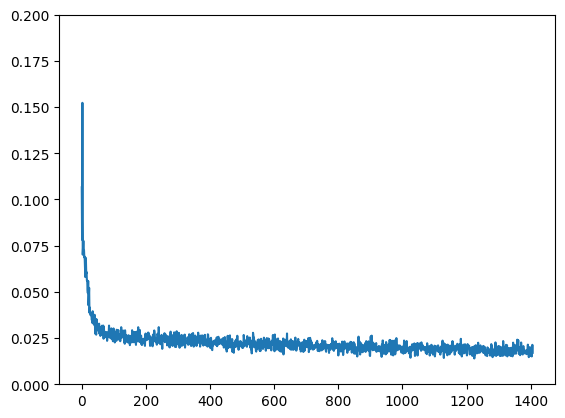

In [8]:
batch_size = 128
train_dataloader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
num_epochs = 3
net.to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=net.parameters(),lr=1e-3)

# 记录训练过程中的损失，供后期查看
losses = []

for epoch in range(num_epochs):
    for x, y in train_dataloader:
        # 得到数据并添加噪声
        x = x.to(device)
        noise_amount = torch.rand(x.shape[0]).to(device) # 随机选取噪声量
        noisy_x = corrupt(x,noise_amount)
        
        pred = net(noisy_x)
        loss = loss_fn(pred,x)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 存储损失
        losses.append(loss.item())
        
    #输出在每个周期训练得到的损失的均值
    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f"Epoch {epoch+1} | Average Loss {avg_loss:.4f}")

# 查看损失曲线
plt.plot(losses)
plt.ylim(0,0.2)
plt.show()
        

我们可以尝试通过抓取一批数据来得到具有不同程度噪声的数据，然后将他们输入模型以获得预测并观察结果。

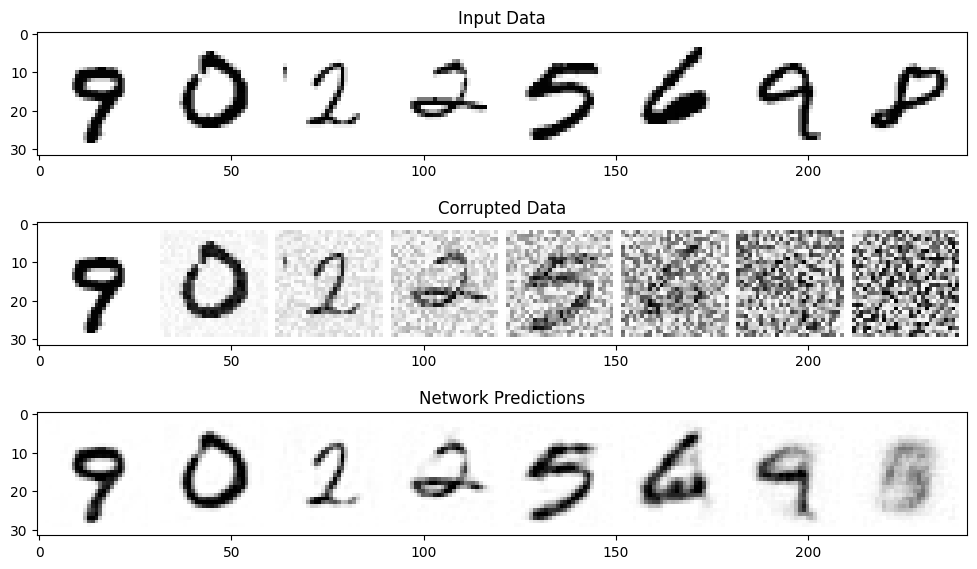

In [9]:
# 可视化模型在"带噪"输入上的表现
x,y = next(iter(train_dataloader))
x = x[:8]

# 在(0,1)区间内选择噪声量的大小
amount = torch.linspace(0,1,x.shape[0])
noised_x = corrupt(x,amount)

# 得到模型的预测结果
with torch.inference_mode():
    preds = net(noised_x.to(device)).detach().cpu()

# 绘图
fig, axs = plt.subplots(3,1,figsize=(12,7))

axs[0].set_title("Input Data")
axs[0].imshow(torchvision.utils.make_grid(x)[0].clip(0,1),cmap='Greys')

axs[1].set_title("Corrupted Data")
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0].clip(0,1),cmap='Greys')

axs[2].set_title("Network Predictions")
axs[2].imshow(torchvision.utils.make_grid(preds)[0].clip(0,1),cmap='Greys')

对于噪声量较低的输入，模型的预测结果相当不错。但是对于噪声量很高的输入，模型能够获得的信息开始减少。而当amount=1的时候，模型将预测一个很模糊的预测，该预测很接近数据集的平均值。扩散模型就是通过这样的方式来预测原始输入的。

#### 上文中各个参数的解释：
##### 代码解析

- **`imshow`**:  
  用于显示图像的 `matplotlib` 函数。`cmap="Greys"` 参数指定使用灰度图（黑到白的颜色范围）。

- **`torchvision.utils.make_grid`**:  
  将多个图像张量拼接成一个网格图像。输入张量通常是 `(B, C, H, W)` 形状，`B` 表示图像数量，`C` 表示通道数，`H` 和 `W` 是图像的高度和宽度。

- **`clip(0, 1)`**:  
  将张量中的值限制在 `[0, 1]` 范围内，确保图像的像素值处于正常显示范围。

- **`cmap="Greys"`**:  
  设定 `imshow` 使用灰度颜色映射，图像会以黑白灰度显示。

##### 代码整体功能
- `make_grid(step_history[i])` 将多个图像拼接成一个网格，`clip(0, 1)` 将像素值限制在 `[0, 1]` 范围，最后 `imshow` 用灰度色调显示图像。

## 4. 扩散模型之采样过程
### 4.1 采样过程

思考：如果模型在高噪声量下的预测结果不是很好，那么应该怎样进行优化呢？

如果我们从完全随机的噪声开始，就应该先检查一下模型的预测结果，然后只朝着预测方向预测一小步，比如20%。 例如，假设我们有一幅夹杂了很多噪声的图像，其中可能隐藏了一些有关输入数据结构的提示，我们可以通过将它输入模型来获得新的预测结果。如果新的预测结果比上一次的预测结果稍微好一点（也就是稍微减少了一些噪声），我们就可以根据这个新的、更好一点的预测结果继续向前迈出一步

**采样过程实际上就是通过逆向扩散的过程，从噪声生成数据的过程**

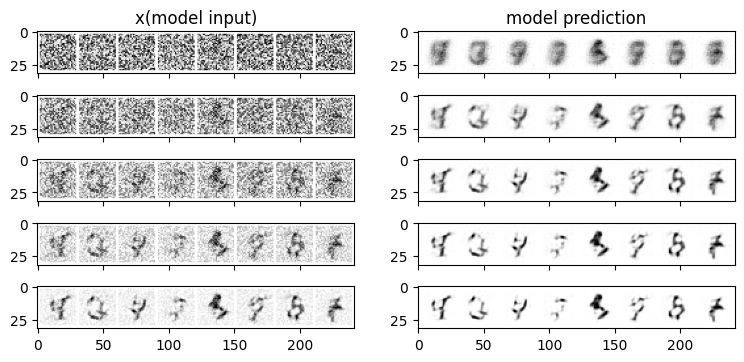

In [10]:
n_steps = 5
x = torch.rand(8,1,28,28).to(device) # 从完全随机的纯噪声开始
step_history = [x.detach().cpu()] # 从计算图中分离一个张量。简单来说，detach() 会创建一个新的张量，该张量与原始张量共享相同的数据，但是不会记录梯度信息，也就不能参与后续的反向传播
pred_output_history = []

for i in range(n_steps):
    with torch.inference_mode():
        pred = net(x) # 预测去噪后的图像
    pred_output_history.append(pred.detach().cpu())
    mix_factor = 1/(n_steps - i) # 设置朝着预测方向移动多少
    x = x*(1-mix_factor) + pred*mix_factor # 移动过程，i越大，mix_factor越大,则移动得越少
    step_history.append(x.detach().cpu())

fig,axs = plt.subplots(n_steps,2,figsize=(9,4),sharex=True)
axs[0,0].set_title("x(model input)")
axs[0,1].set_title("model prediction")
for i in range(n_steps):
    axs[i,0].imshow(torchvision.utils.make_grid(step_history[i])[0].clip(0,1),cmap="Greys")
    axs[i,1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0].clip(0,1),cmap="Greys")


如果一切顺利，重复以上过程几次以后，我们就能得到一幅全新的图像。

当然，也可以加多步骤，以获得质量更高的图像

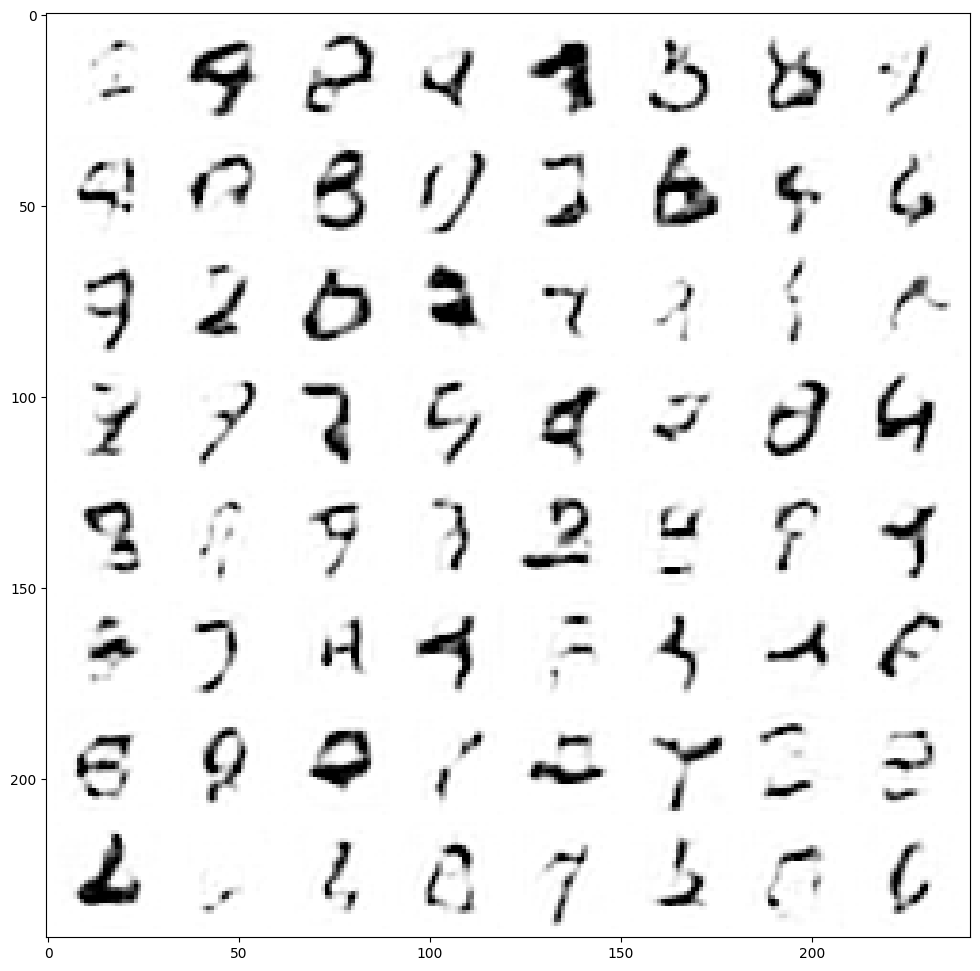

In [11]:
n_steps = 40
x = torch.rand(64,1,28,28).to(device)
for i in range(n_steps):
    noise_amount = torch.ones((x.shape[0],)).to(device) * (1-(i/n_steps)) # 噪声量从高到低
    with torch.inference_mode():
        pred = net(x)
    mix_factor = 1/(n_steps-i)
    x = x*(1-mix_factor) + pred*mix_factor
fig,axs = plt.subplots(1,1,figsize=(12,12))
axs.imshow(torchvision.utils.make_grid(x.detach().cpu(),nrow=8)[0].clip(0,1),cmap="Greys")

看起来输出结果没有那么好，但是已经可以认出几个数字了，我们可以尝试通过训练更长时间并调整模型配置、学习率、优化器等。

### 4.2 与DDPM的区别
下面将介绍所展示的模型版本与Diffusers库中DDPM版本实现过程的区别，知识点如下：
- UNet2DModel模型结构相比BasicUNet模型结构更先进
- 退化过程的处理方式不同
- 训练目标不同，旨在预测噪声而不是“去噪”的图像
- UNet2DModel模型通过调节时间步来调节噪声量，$t$ 作为一个额外参数被传入前向过程
- 有更多种类的采样策略可供选择

### 4.3 UNet2DModel模型
Diffusers库中的UNet2DModel模型相比于BasiUNet模型做了如下改进：
- GroupNorm层对每个模块的输入进行了组标准化
- Dropout层能使得训练更平滑
- 每个块有多个ResNet层（如果layers_per_block没有被设置为1）
- 引入了注意力机制（通常仅用于输入分辨率较低的block）
- 可以对时间步进行调节
- 具有可学习参数的上采样模块和下采样模块

In [12]:
model = UNet2DModel(
    sample_size=28, # 目标图像的像素
    in_channels=1, # 输入图像的通道数
    out_channels=1, # 输出图像的通道数
    layers_per_block=2, # 设置在每一个UNet块中使用多少个RenNet层
    block_out_channels=(32,64,64), # 与BasicUNet模型的配置基本相同
    down_block_types=(
        "DownBlock2D", # 标准的ResNet下采样模块
        "AttnDownBlock2D", # 带有空域维度self-att的ResNet下采样模块
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D", # 带有空域维度self-att的ResNet上采样模块
        "UpBlock2D", # 标准的ResNet上采样模块
    ),
    
)
print(model)

UNet2DModel(
  (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=32, out_features=128, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
          (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(32, 32, ker

UNet2DModel模型的参数量要比BasicUNet模型大得多。

In [13]:
sum([p.numel() for p in model.parameters()])

1707009

使用UNet2DModel模型代替BasicUNet模型，重复前面的训练过程。为此我们需要将原始图像和时间步输入进去（这里传递 $t=0$ ，以表明模型是在没有时间步的情况下工作的，同时需要保持采样代码足够简单、清晰。也可以尝试输入 $amount\times1000$ ，以使时间步与噪声水平相当）

Epoch 1 | Average Loss 0.0200
Epoch 2 | Average Loss 0.0130
Epoch 3 | Average Loss 0.0116


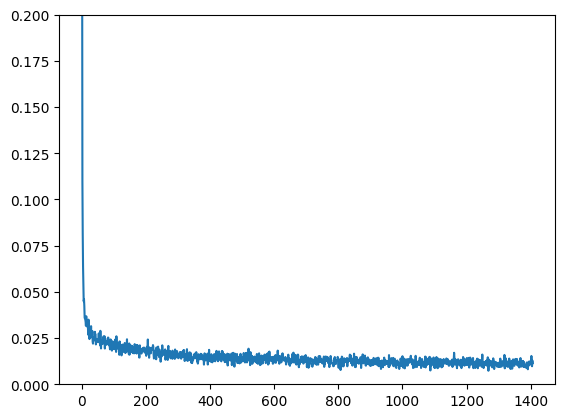

In [14]:
batch_size = 128
train_dataloader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
num_epochs = 3
model.to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters(),lr=1e-3)

# 记录训练过程中的损失，供后期查看
losses = []

for epoch in range(num_epochs):
    for x, y in train_dataloader:
        # 得到数据并添加噪声
        x = x.to(device)
        noise_amount = torch.rand(x.shape[0]).to(device) # 随机选取噪声量
        noisy_x = corrupt(x,noise_amount)
        
        time_step = torch.zeros((x.shape[0],)).to(device)
        
        pred = model(noisy_x,time_step)
        output = pred.sample
        loss = loss_fn(output,x)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 存储损失
        losses.append(loss.item())
        
    #输出在每个周期训练得到的损失的均值
    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f"Epoch {epoch+1} | Average Loss {avg_loss:.4f}")

# 查看损失曲线
plt.plot(losses)
plt.ylim(0,0.2)
plt.show()

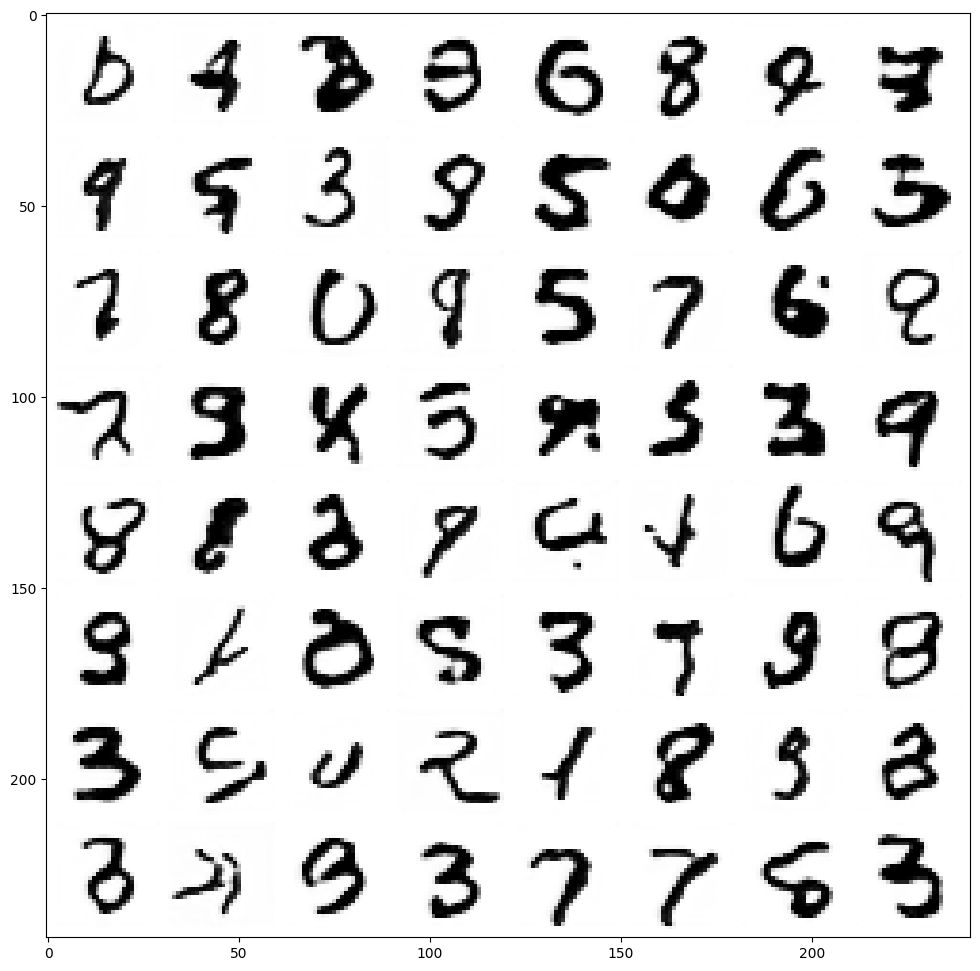

In [18]:
n_steps = 40
x = torch.rand(64,1,28,28).to(device)
for i in range(n_steps):
    noise_amount = torch.ones((x.shape[0],)).to(device) * (1-(i/n_steps)) # 噪声量从高到低
    time_step = torch.zeros((x.shape[0],)).to(device)
    with torch.inference_mode():
        pred = model(x,time_step)
        output = pred.sample
    mix_factor = 1/(n_steps-i)
    x = x*(1-mix_factor) + output*mix_factor
fig,axs = plt.subplots(1,1,figsize=(12,12))
axs.imshow(torchvision.utils.make_grid(x.detach().cpu(),nrow=8)[0].clip(0,1),cmap="Greys")

这组结果看起来比第一组好多了！

## 5. 扩散模型之退化过程示例
### 5.1 退化过程
DDPM论文描述了一个在每个时间步都为输入图像添加少量噪声的退化过程。如果在某个时间步给定 $x_{t-1}$ ，就可以得到一个噪声稍微增强的 $x_{t}$：
$$
q(x_{t}|x_{t-1}) = \mathcal{N}(x_{t};\sqrt{1-\beta_{t}}\,x_{t-1},\beta_{t}I)
$$

$$
q(x_{1:T}|x_{0}) = \prod_{t=1}^{T}q(x_{t}|x_{t-1})
$$
这样理解：取 $x_{t-1}$ ，给他一个系数 $\sqrt{1-\beta_{t}}$ ，然后将其与一个带有系数 $\beta_{t}$ 的噪声相加。其中， $\beta$ 是我们根据调度器为每个时刻设定的参数，用于决定在每个时间步添加的噪声量。我们并不想通过把这个推演重复 $n$ 次来得到 $x_{n}$ ，而是希望利用另一公式，根据给出的 $x_{0}$ 计算得到任意时刻 $t$ 的 $x_{t}$：
$$
q(x_{t}|x_{0}) = \mathcal{N}(x_{t};\sqrt{\bar\alpha_{t}}\,x_{0},\,(1-\bar\alpha_{t})I);\,其中\bar\alpha_{t} = \prod_{t=1}^{T}\alpha_{i},\,\alpha_{i} = 1-\beta_{i}
$$
好吓人！但是调度器能够为我们处理所有这些流程（本节中你可以尝试代码 `nois_scheduler.add_noise`）。我们可以画出 $\sqrt{\bar\alpha_{t}}$ 和 $\sqrt{(1-\bar\alpha_{t})}$ 的趋势图，看一看输入与噪声是怎样在不同迭代周期中量化和叠加的。

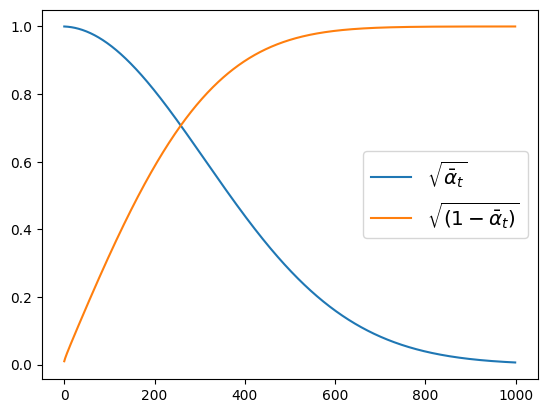

In [20]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
plt.plot(noise_scheduler.alphas_cumprod.cpu()**0.5,label=r"$\sqrt{\bar\alpha_{t}}$")
plt.plot((1-noise_scheduler.alphas_cumprod.cpu())**0.5,label=r"$\sqrt{(1-\bar\alpha_{t})}$")
plt.legend(fontsize="x-large")

一开始，输入X中绝大部分是输入X本身的值，因为 $\sqrt{\bar\alpha_{t}} \approx 1$ ，但是随着谁建的推移，输入X的成分逐渐降低，而噪声的成分逐渐增加。

与根据amount对输入X和噪声进行线性混合不同，这个噪声的增加速度相对较快。

X shape torch.Size([8, 1, 28, 28])
Noisy X shape torch.Size([8, 1, 28, 28])


Text(0.5, 1.0, 'Noisy X')

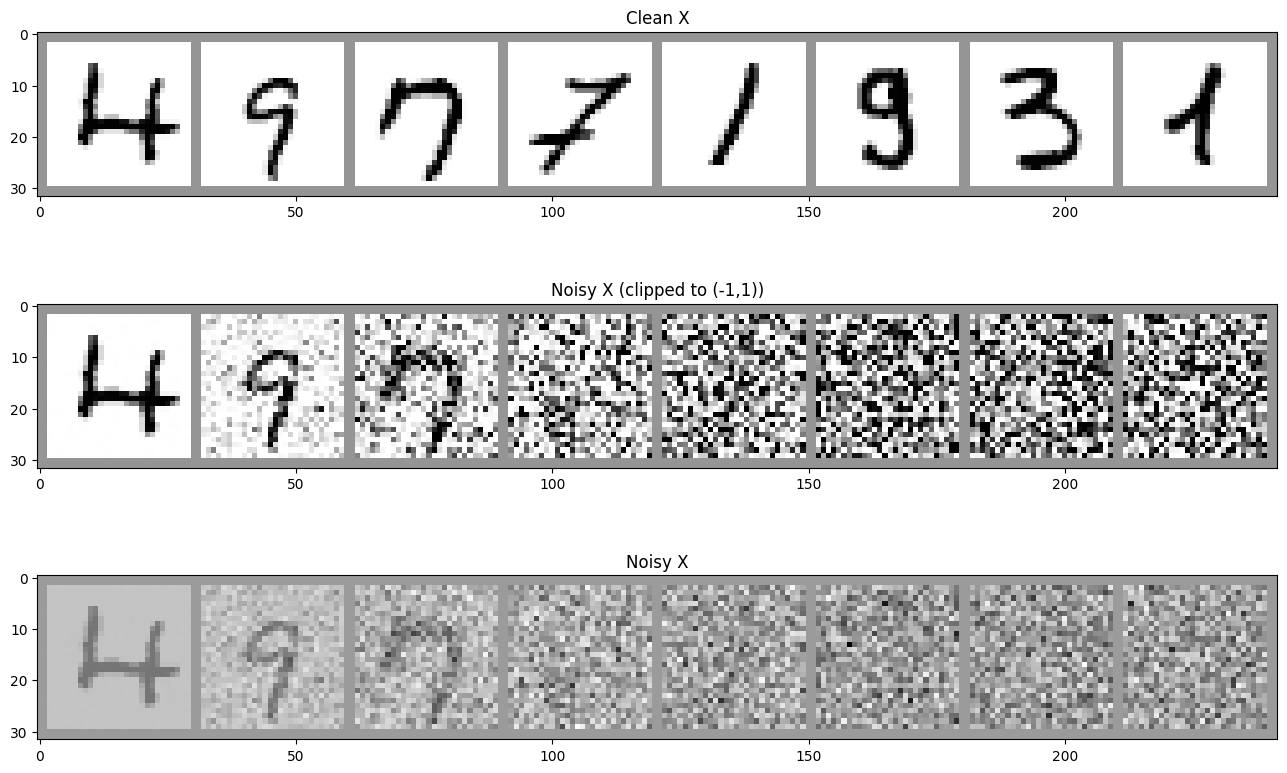

In [22]:
# 可视化：DDPM加噪过程中的不同时间步
# 对一批图片加噪，看看效果
fig,axs = plt.subplots(3,1,figsize=(16,10))
xb,yb = next(iter(train_dataloader))
xb = xb.to(device)[:8]
xb = xb*2. - 1. # 映射到(-1,1)
print("X shape",xb.shape)

# 展示干净的原始输入
axs[0].imshow(torchvision.utils.make_grid(xb[:8])[0].detach().cpu(),cmap="Greys")
axs[0].set_title("Clean X")

# 使用调度器加噪
timesteps = torch.linspace(0,999,8).long().to(device)
noise = torch.randn_like(xb) # 注意使用的是randn而不是rand,也就是用了正态分布
noisy_xb = noise_scheduler.add_noise(xb,noise,timesteps)
print("Noisy X shape",noisy_xb.shape)

# 展示“带噪”的版本
axs[1].imshow(torchvision.utils.make_grid(noisy_xb[:8])[0].detach().cpu().clip(-1,1),cmap="Greys")
axs[1].set_title("Noisy X (clipped to (-1,1))")

axs[2].imshow(torchvision.utils.make_grid(noisy_xb[:8])[0].detach().cpu(),cmap="Greys")
axs[2].set_title("Noisy X")


在DDPM版本中，加入的噪声取自一个高斯分布(`torch.randn`)，而非我们在原始退化函数中使用的均匀分布(`torch.rand`)。当然，对训练数据进行正则化也可以理解，后面你会看到归一化函数`normalize(0.5,0.5)`在变化列表中把图片数据从 $(0,1)$ 映射到 $(-1,1)$ ，这对我们的使用目的来说足够了。

### 5.2 最终的训练目标
我们原本是让模型预测“去噪”后的图像。在DDPM和许多其他扩散模型的实现中，模型会预测退化过程中使用的噪声（预测的是不带缩放系数的噪声，也就是单位正态分布的噪声）。

In [24]:
noise = torch.randn_like(xb)
noisy_x = noise_scheduler.add_noise(xb,noise,timesteps)
model_prediction = model(noisy_x,timesteps).sample
loss = loss_fn(model_prediction,noise) # 预测结果与噪声的MSE

为什么要预测噪声而不是直接预测“去噪”的图像？？

我们在训练过程中会计算不同（随机选择）时间步的损失函数，不同任务目标计算得到的结果会根据损失值向不同的“隐含权重”收敛，而“预测噪声”这个目标会使权重更倾向于预测得到更低的噪声量。你可以通过选择更复杂的目标来改变这种“隐形损失权重”，这样你所选择的噪声调度器就能够直接在高噪声量情况下产生更多样本。

## 6. 扩展知识
### 6.1 时间步的调节
UNet2DModel模型以图片和时间步为输入。其中，时间步可转换为嵌入，然后在多个地方被输入模型。

背后的理论支持是：通过向模型提供有关噪声量的信息，模型可以更好地执行任务。虽然在没有时间步的情况下也可以训俩模型，但在某些情况下，时间步的确有助于模型性能的提升。目前来看，绝大多数模型的实现都使用了时间步。

### 采样（取样）的关键问题
假设一个模型可以用来预测“带噪”样本中的噪声（或者说能预测其“去噪”版本），那么我们怎么用它生成图像呢？

我们可以输入纯噪声，然后期待模型能一步就输出一幅不带噪声的图像。但是根据我们前面所学的内容，这显然行不通。所以我们应该在模型预测的基础上使用足够多的小步，不断迭代，每次去除一点点噪声。

具体怎么走完这些小步取决于上面的采样方法，你需要考虑以下3个问题：

1. 你每一步想走多远？也就是说，你制定什么样的“噪声计划”？
2. 你只使用模型当前步的预测结果指导下一步的预测方向吗（采用DDPM、DDIM或其他什么方式）？你是否想要使用模型多预测几次，以通过估计一个更高阶的梯度来更新得到更准确的结果（更高阶的方法和一些离散ODE处理器）？抑或保留一些历史的预测值来尝试指导当前步的更新（线性多步活遗传采样器）？
3. 你是否会在采样过程中额外添加一些随机噪声或完全确定的噪声？许多采样器通过提供参数（如DDIM中的'eta'）来让用户做出选择。 